## 试试可视化


In [1]:
"""
绘制测井曲线，并标注层位信息
从浅到深显示目的层的测井数据
"""

import os

import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

# 设置中文字体支持
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# ============ 1. 读取数据 ============
# 读取层位数据
horizon_file = os.path.join("..", "data", "well_horizon.xlsx")
horizon_df = pd.read_excel(horizon_file, sheet_name="Sand Thickness")

# 筛选井数据并按深度排序（从浅到深）
ph1_horizons = horizon_df[horizon_df["Well"] == "PH6"].copy()
ph1_horizons = ph1_horizons.sort_values("MD").reset_index(drop=True)

print("PH6 井的层位信息（从浅到深）：")
print(ph1_horizons)
print("-" * 60)

# 读取 LAS 文件
las_file = os.path.join("..", "data", "vertical_well_las", "PH6.las")
las = lasio.read(las_file)

print(f"\n成功读取 LAS 文件: {las_file}")
print(f"深度范围: {las.index[0]:.2f} - {las.index[-1]:.2f} m")
print(f"可用曲线: {las.keys()[:10]}...")  # 显示前10条曲线


PH6 井的层位信息（从浅到深）：
          X          Y       Z  TWT picked  TWT auto  Geological age       MD  \
0  687756.4  3223209.6 -2257.2        -999  -1974.01            -999  2280.26   
1  687756.2  3223209.6 -2289.8        -999  -1994.41            -999  2312.84   
2  687756.0  3223209.6 -2324.5        -999  -2015.51            -999  2347.54   
3  687755.8  3223209.7 -2357.6        -999  -2035.38            -999  2380.61   
4  687755.7  3223209.7 -2367.6        -999  -2041.54            -999  2390.70   
5  687754.0  3223209.8 -2625.7        -999  -2192.10            -999  2648.81   
6  687753.6  3223209.9 -2696.5        -999  -2229.23            -999  2719.59   
7  687753.0  3223209.9 -2795.0        -999  -2297.59            -999  2818.05   
8  687752.7  3223210.0 -2827.6        -999  -2302.17            -999  2850.70   

   PVD auto     Type      Surface  ... TST zone Observation number  \
0   -2257.2  Horizon         H1-1  ...     -999               -999   
1   -2289.8  Horizon         H1

In [2]:
# ============ 2. 选择要显示的关键测井曲线 ============
# 根据报告，选择常用的地球物理曲线
curves_to_plot = {
    "GR": {"color": "green", "range": (0, 150), "label": "GR (gAPI)"},
    "GAMMA": {"color": "green", "range": (0, 150), "label": "GR (gAPI)"},
    "DT": {"color": "blue", "range": (40, 240), "label": "DT (us/ft)"},
    "AC": {"color": "blue", "range": (40, 240), "label": "AC (us/ft)"},
    "DEN": {"color": "red", "range": (1.95, 2.95), "label": "DEN (g/cm3)"},
    "RHOB": {"color": "red", "range": (1.95, 2.95), "label": "RHOB (g/cm3)"},
    "NPHI": {"color": "cyan", "range": (0, 0.45), "label": "NPHI (v/v)"},
    # "RT": {"color": "purple", "range": (0.2, 2000), "label": "RT (ohm.m)", "log": True},
    "LLD": {"color": "purple", "range": (0.2, 2000), "label": "LLD (ohm.m)", "log": True},
    "CAL": {"color": "brown", "range": (6, 20), "label": "CALI (in)"},
    "CALI": {"color": "brown", "range": (6, 20), "label": "CALI (in)"},
}


# 检查曲线是否存在
available_curves = {}
for curve_name, props in curves_to_plot.items():
    if curve_name in las.keys():
        available_curves[curve_name] = props
    else:
        print(f"警告: 曲线 {curve_name} 不存在于 LAS 文件中")

print(f"\n将绘制的曲线: {list(available_curves.keys())}")

警告: 曲线 GAMMA 不存在于 LAS 文件中
警告: 曲线 AC 不存在于 LAS 文件中
警告: 曲线 RHOB 不存在于 LAS 文件中
警告: 曲线 NPHI 不存在于 LAS 文件中
警告: 曲线 LLD 不存在于 LAS 文件中
警告: 曲线 CAL 不存在于 LAS 文件中
警告: 曲线 CALI 不存在于 LAS 文件中

将绘制的曲线: ['GR', 'DT', 'DEN']


In [3]:
# ============ 3. 确定绘图的深度范围 ============
if len(ph1_horizons) > 0:
    min_depth = max(ph1_horizons["MD"].min() - 50, las.index[0])  # 最浅层位上方50米
    max_depth = min(ph1_horizons["MD"].max() + 50, las.index[-1])  # 最深层位下方50米
else:
    min_depth = las.index[0]
    max_depth = las.index[-1]

print(f"\n绘图深度范围: {min_depth:.2f} - {max_depth:.2f} m")


绘图深度范围: 2230.26 - 2900.70 m


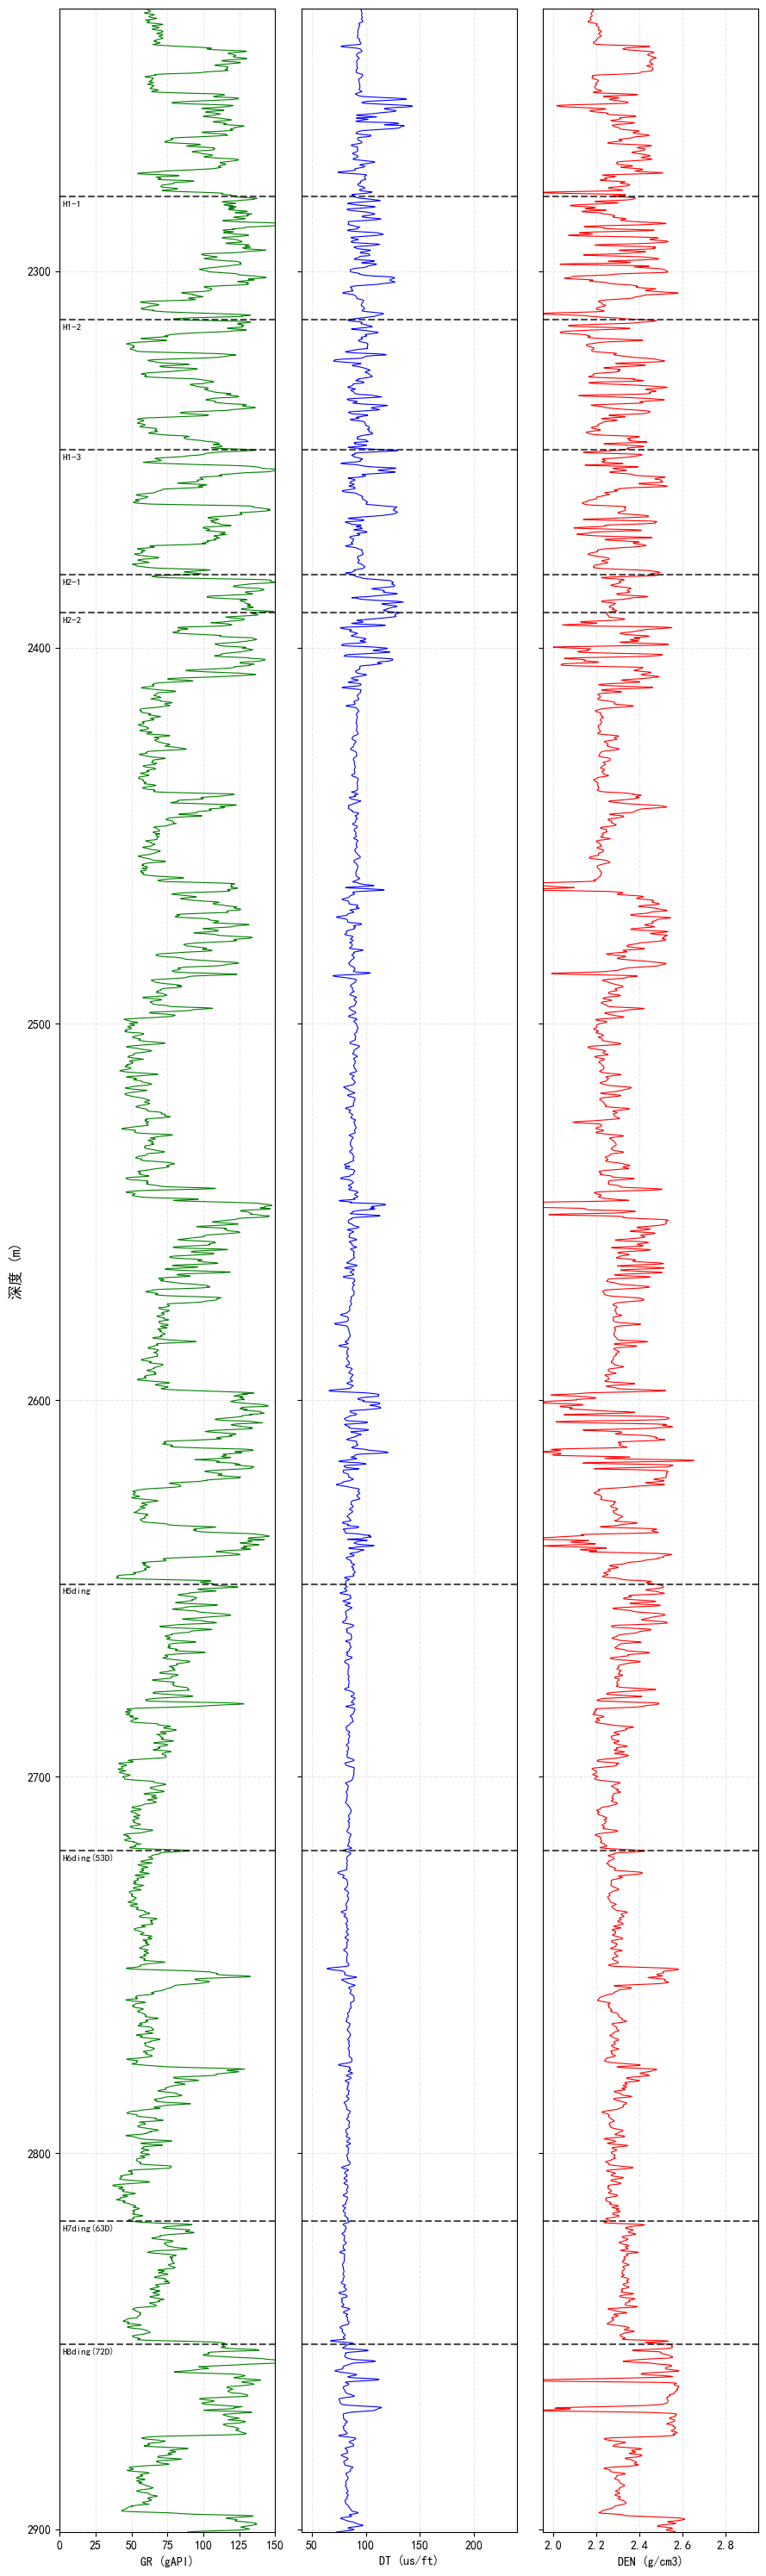

In [4]:
# ============ 4. 绘制测井曲线 ============
n_tracks = len(available_curves)
fig, axes = plt.subplots(1, n_tracks, figsize=(3 * n_tracks, 30), sharey=True)

if n_tracks == 1:
    axes = [axes]

# fig.suptitle(f"PH1 井测井曲线综合图（从浅到深）", fontsize=16, fontweight="bold")

# 为每个道绘制曲线
for idx, (curve_name, props) in enumerate(available_curves.items()):
    ax = axes[idx]

    # 获取曲线数据
    curve_data = las[curve_name]
    depth = las.index

    # 筛选深度范围内的数据
    mask = (depth >= min_depth) & (depth <= max_depth)
    plot_depth = depth[mask]
    plot_data = curve_data[mask]

    # 绘制曲线
    if props.get("log", False):
        ax.semilogx(plot_data, plot_depth, color=props["color"], linewidth=0.8)
    else:
        ax.plot(plot_data, plot_depth, color=props["color"], linewidth=0.8)

    # 设置坐标轴
    ax.set_ylim(max_depth, min_depth)  # 深度从上到下
    ax.set_xlim(props["range"])
    ax.set_xlabel(props["label"], fontsize=10)
    ax.grid(True, alpha=0.3, linestyle="--")

    # 只在第一个道显示深度标签
    if idx == 0:
        ax.set_ylabel("深度 (m)", fontsize=12, fontweight="bold")

    # ============ 5. 标注层位 ============
    for _, horizon in ph1_horizons.iterrows():
        horizon_depth = horizon["MD"]
        surface_name = horizon["Surface"]
        sand_thickness = horizon["Sand Thickness"]

        # 如果在绘图范围内
        if min_depth <= horizon_depth <= max_depth:
            # 绘制层位线
            ax.axhline(y=horizon_depth, color="black", linewidth=1.5, linestyle="--", alpha=0.7, zorder=10)

            # 在第一个道添加层位名称标注
            if idx == 0:
                ax.text(
                    props["range"][0] + 2,
                    horizon_depth + 2,
                    f"{surface_name}",
                    verticalalignment="center",
                    fontsize=8,
                    # bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7, edgecolor="black"),
                )

plt.tight_layout()

In [5]:
# ============ 6. 保存图像 ============
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "PH1_well_logs_with_horizons.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")
print(f"\n✓ 图像已保存到: {output_file}")

plt.show()


✓ 图像已保存到: output\PH1_well_logs_with_horizons.png


<Figure size 640x480 with 0 Axes>

In [6]:
# ============ 7. 输出层位统计信息 ============
print("\n" + "=" * 60)
print("层位统计信息：")
print("=" * 60)
for idx, row in ph1_horizons.iterrows():
    print(f"{idx + 1}. {row['Surface']:20s} | 深度: {row['MD']:7.2f} m | 砂岩厚度: {row['Sand Thickness']:6.2f} m")  # type: ignore
print("=" * 60)


层位统计信息：
1. H1-1                 | 深度: 2280.26 m | 砂岩厚度:   8.80 m
2. H1-2                 | 深度: 2312.84 m | 砂岩厚度:  16.60 m
3. H1-3                 | 深度: 2347.54 m | 砂岩厚度:  13.70 m
4. H2-1                 | 深度: 2380.61 m | 砂岩厚度:   1.00 m
5. H2-2                 | 深度: 2390.70 m | 砂岩厚度: 151.80 m
6. H5ding               | 深度: 2648.81 m | 砂岩厚度:  56.50 m
7. H6ding(53D)          | 深度: 2719.59 m | 砂岩厚度:  91.65 m
8. H7ding(63D)          | 深度: 2818.05 m | 砂岩厚度:  28.75 m
9. H8ding(72D)          | 深度: 2850.70 m | 砂岩厚度: -999.00 m
